In [1]:
from rich.progress import track
import pandas as pd
import matplotlib.pyplot as plt
import user_db
import datetime
from dateutil.relativedelta import relativedelta

In [2]:
conn = user_db.tuple_cursor()

log_df = pd.read_sql_query("SELECT * FROM Log", conn)

In [3]:
len(log_df)

683717

In [4]:
query = 'SELECT COUNT(DISTINCT ip) FROM Log WHERE NOT page_category = "/"'
print(conn.execute(query).fetchone()[0])
conn.close()

31118


In [5]:
current_date = datetime.datetime.now().date()
valid_months = []
start_date = []
end_date = []

for year in range(2023, (current_date.year + 1)):
    for month in range(1,13):
        start_date.append(datetime.datetime(year, month, 1))
        end_date.append(datetime.datetime(year, month, 1) + relativedelta(months=1) - datetime.timedelta(microseconds=1))
        valid_months.append(f'{month}-{year}')
        # don't fetch months that haven't happened yet
        if year == current_date.year and month == current_date.month:
            break

In [6]:
page_views = []
unique_users = []

with user_db.tuple_cursor() as conn:
    for start, end in zip(start_date, end_date):
        params = (start, end)
        query = "SELECT COUNT(DISTINCT ip) FROM Log WHERE timestamp BETWEEN ? AND ?"
        unique_users.append(conn.execute(query, params).fetchone()[0])

        query = "SELECT COUNT(*) FROM Log WHERE timestamp BETWEEN ? AND ?"
        page_views.append(conn.execute(query, params).fetchone()[0])

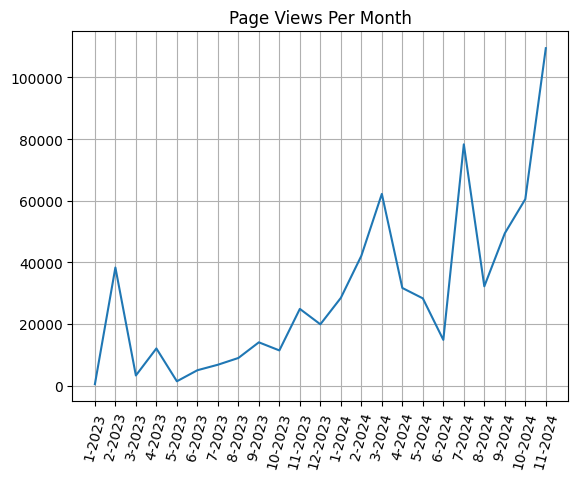

In [14]:
plt.plot(valid_months, page_views)
plt.xticks(rotation=75)
plt.title('Page Views Per Month')
plt.grid()

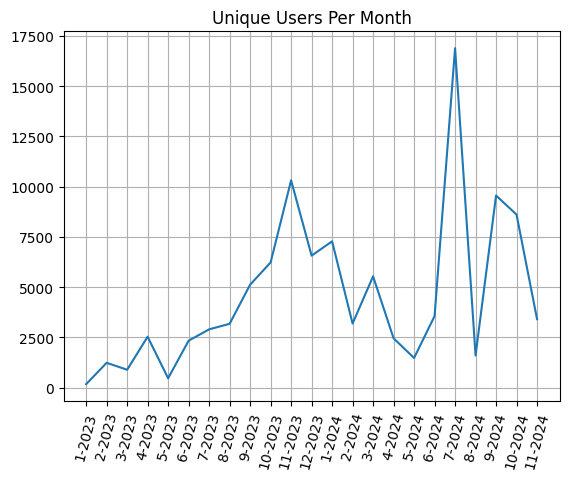

In [13]:
plt.plot(valid_months, unique_users)
plt.xticks(rotation=75)
plt.title('Unique Users Per Month')
plt.grid()

Unique Monthly Users has a fair bit of unexplained variability. Despite an overall strong upward trend for page views, unique users has been far more up and down overall. July of 2024 is especially strange given that it is during the off season, and I had server troubles plauging me throughout this past summer (finally fully resolved in late August). Perhaps a higher amount of bots were interested in poking around?

In [10]:
page_list = ['/', '/about', '/search', '/explore', '/rankings', '/trail-rankings', '/lift-rankings', '/map', '/interactive-map']
page_views_by_page = []
unique_users_by_page = []

with user_db.tuple_cursor() as conn:
    for page in page_list:
        query = "SELECT COUNT(*) FROM Log WHERE page_category = ?"
        params = (page,)
        page_views_by_page.append(conn.execute(query, params).fetchone()[0])

        query = "SELECT COUNT(DISTINCT ip) FROM Log WHERE page_category = ?"
        params = (page,)
        unique_users_by_page.append(conn.execute(query, params).fetchone()[0])

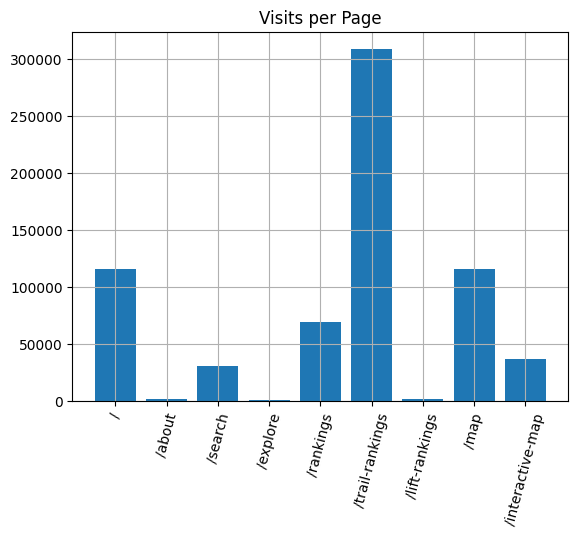

In [11]:
plt.bar(page_list, page_views_by_page)
plt.xticks(rotation=75)
plt.title('Visits per Page')
plt.grid()

About and Explore recieve much less traffic than the other pages. About makes sense, but I'm suprised how little Explore is used. Probably something to investigate further to figure out why. As of 11/22/24 when I am writing this, Lift Rankings is extremely new and therefore not suprising that it has seen so little traffic. I'm amazed at just how much of the site's traffic is solely on the Trail Rankings page. Apparantly that is the most popular feature of the site, and is worth capitalizing on. Part of this may be that each time a user changes the sorting or filters it is logged as a seprate visit.

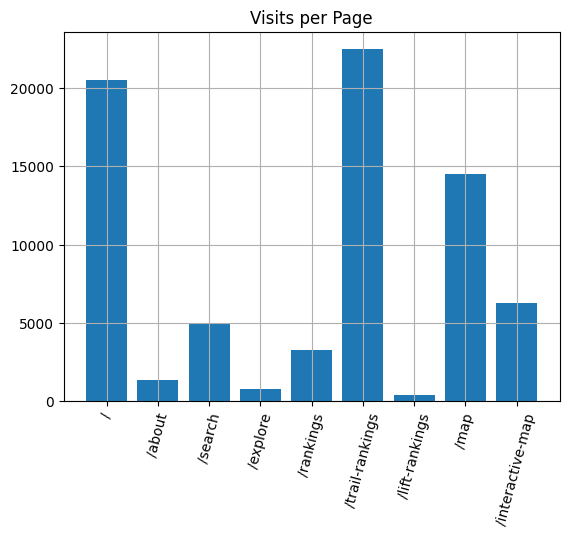

In [12]:
plt.bar(page_list, unique_users_by_page)
plt.xticks(rotation=75)
plt.title('Visits per Page')
plt.grid()